In [160]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from zoneinfo import ZoneInfo

Text(0, 0.5, 'Temperature [°C]')

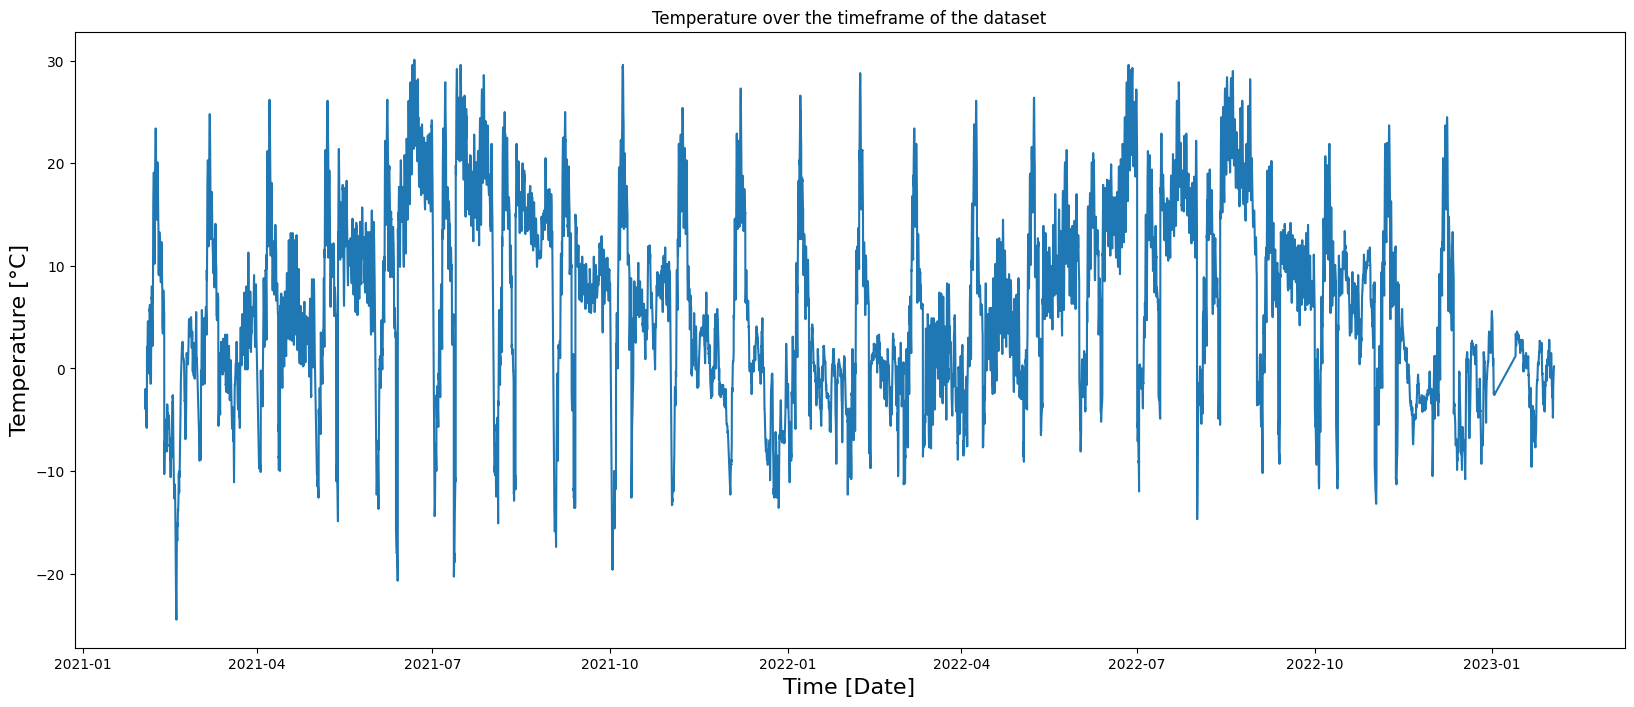

In [161]:
# import dataset and transform timestamp
df = pd.read_csv('data/solar_243171.csv', delimiter=',', decimal='.')
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms', utc=True).map(lambda x: x.tz_convert('Europe/Tallinn'))

if pd.Series(df["timestamp"]).is_unique:
    df.set_index('timestamp', inplace=True)

# show temperature first
plt.figure(figsize=(20,8))
plt.title("Temperature over the timeframe of the dataset")
p = sns.lineplot(data=df['temperature'])
p.set_xlabel("Time [Date]", fontsize=16)
p.set_ylabel("Temperature [°C]", fontsize=16)

Text(0, 0.5, 'Production [MW]')

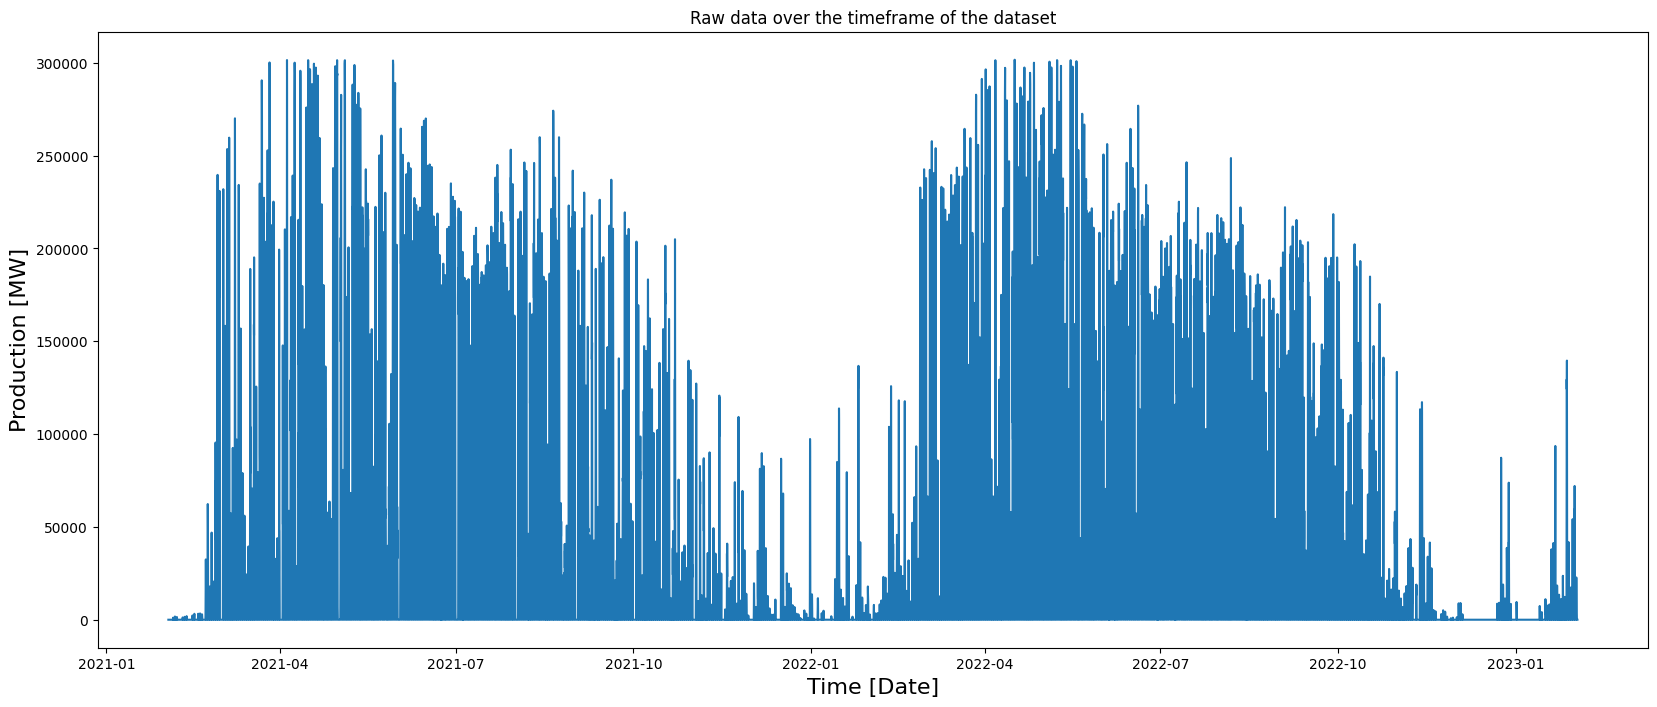

In [162]:
#show raw data
plt.figure(figsize=(20,8))
plt.title("Raw data over the timeframe of the dataset")
p = sns.lineplot(data=df['raw'])
p.set_xlabel("Time [Date]", fontsize=16)
p.set_ylabel("Production [MW]", fontsize=16)

In [163]:
# weather dataset for comparison -> are the timestamps in UNIX UTC?
df_weather = pd.read_csv('data/Tallinn-Harku-2004-juuni-2024.csv', delimiter=';', decimal=',') # source: https://www.ilmateenistus.ee/wp-content/uploads/2024/07/Tallinn-Harku-2004-juuni-2024.xlsx
df_weather['timestamp'] = pd.to_datetime(df_weather[['year', 'month', 'day']].astype(str).agg('-'.join, axis=1) + ' ' + df_weather['time'], utc=True).map(lambda x: x.tz_convert('Europe/Tallinn'))
if pd.Series(df_weather["timestamp"]).is_unique:
    df_weather.set_index('timestamp', inplace=True)

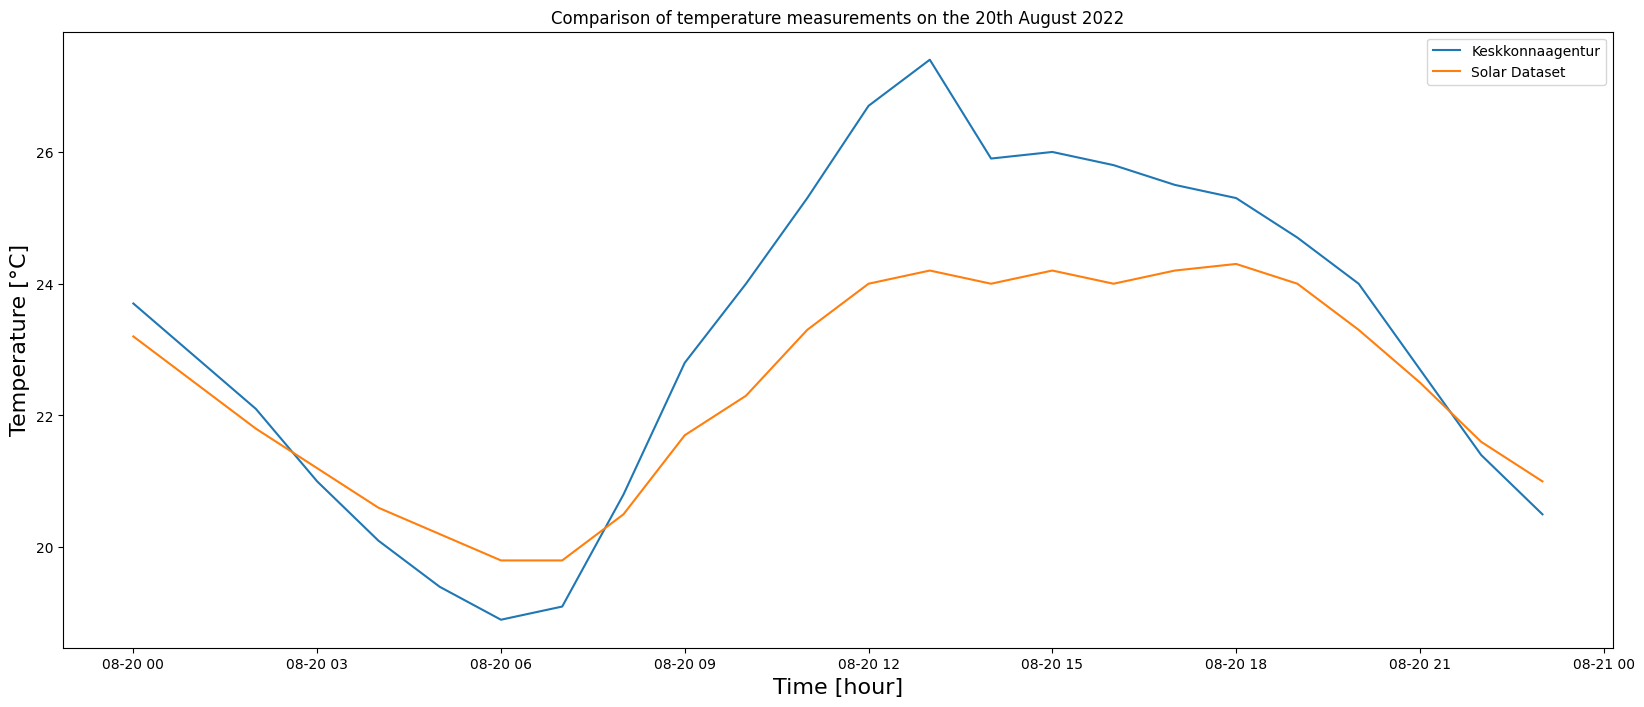

In [164]:
# comparison graph
start_date = datetime(2022, 8,20, tzinfo=ZoneInfo("Europe/Tallinn"))
end_date = datetime(2022, 8, 21, tzinfo=ZoneInfo("Europe/Tallinn"))

temperature_dataset = df['temperature'][(df['temperature'].index >= start_date) &  (df['temperature'].index < end_date)]
temperature_keskkonnaagentuur  = df_weather['temp'][(df_weather['temp'].index >= start_date) &  (df_weather['temp'].index < end_date)]

plt.figure(figsize=(20,8))
plt.title("Comparison of temperature measurements on the 20th August 2022")
p = sns.lineplot(data=temperature_keskkonnaagentuur, label="Keskkonnaagentur")
p = sns.lineplot(data=temperature_dataset, label="Solar Dataset")
p.set_xlabel("Time [hour]", fontsize=16)
p.set_ylabel("Temperature [°C]", fontsize=16)
plt.savefig("diagrams/diagram_comparison_weather_data.pdf")